In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import datasets
from torchvision import transforms

/home/juxiaobing/anaconda3/envs/pocket/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<br>

## Define Teacher and Student Network

<br>

## Prepare Dataset

In [ ]:
transform = transforms.Compose([transforms.Grayscale(3), # Match the mnist channel dim with vgg19 input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])

mnist = datasets.MNIST(root='/home/juxiaobing/code/GraduationProject/Novelty_Detection/mnist/MNIST/raw', 
                       train=True, 
                       download=True,
                       transform=transform)

train_loader = DataLoader(dataset=mnist,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

<br>

## Train Student Network

In [2]:
import torch
import torch.nn.functional as F
import glob
import os
from collections import OrderedDict
from sortedcontainers import SortedDict, SortedSet
import cv2
import numpy as np
import tqdm


class TrajectoryDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset_dir="/home/juxiaobing/code/GraduationProject/CNN-VAE/data/T15/T15_images", labels: SortedSet = {1}):

        self.extract_labels = labels
        self.dataset_dir = dataset_dir
        self.length = 0
        self.img_labels_ = self.get_labels()
        self.img_dicts = {}
        self.read_imgs()

    def get_labels(self):
        class_dirs = os.path.join(self.dataset_dir, '*')
        paths = glob.glob(class_dirs)
        labels = []
        for path in paths:
            label = (int)(path.split('/')[-1])
            if label in self.extract_labels:
                img_paths = glob.glob(os.path.join(path, '*.jpg'))
                for img_path in img_paths:
                    labels.append([img_path, label])
                self.length += len(img_paths)
        return labels

    def read_imgs(self):
        print("Load images .... ")
        for idx in tqdm.tqdm(range(self.length)):
            self.img_dicts[idx] = self.read_img(self.img_labels_[idx][0])

    def read_img(self, img_path, need_trasform=True):

        cvimg = cv2.imread(img_path)

        if need_trasform:
            cvimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB)
        
        cvimg = np.transpose(np.array(cvimg, np.float32), [2, 0, 1])

        return cvimg

    def __len__(self):
        return self.length

    def __getitem__(self, idx: int):
        if idx not in self.img_dicts:
            self.img_dicts[idx] = self.read_img(self.img_labels_[idx][0])
        return self.img_dicts[idx], self.img_labels_[idx][1]


In [ ]:
train_dataset = TrajectoryDataset(labels={1})

In [7]:
BATCH_SIZE = 8

train_dataset = TrajectoryDataset(labels={1,2,3,4})

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

DEVICE = 'cuda:0'
EPOCHS = 1000
BASEBONE = "resnet101"

model_path = os.path.join(os.getcwd(),"models")

if not os.path.exists(model_path):
    os.mkdir(model_path)

student_net_path = os.path.join(model_path,"stu_net.pth")
teacher_net_path = os.path.join(model_path,"tea_net.pth")


if os.path.exists(student_net_path):
    student = torch.load(student_net_path)
    print("stu load from ",student_net_path)
else:
    restnet = models.resnet101(pretrained=False)
    student = restnet.to(DEVICE)
    
if os.path.exists(teacher_net_path):
    teacher = torch.load(teacher_net_path)
else:    
    pretrained_resnet = models.resnet101(pretrained=True)
    # teacher = pretr16

teacher.eval()

if os.path.exists(student_net_path):
    student = torch.load(student_net_path)
    print("stu load from ",student_net_path)


criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(student.parameters(), lr=0.0002, weight_decay=0.00001)

for epoch in range(EPOCHS):
    total_loss = 0
    total_iters = 0
    for data in train_loader:
        total_iters = total_iters + 1
        img = data[0].to(DEVICE)
        with torch.no_grad():
            surrogate_label = teacher(img)
        optimizer.zero_grad()
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()
    print("Epoch:%d"%(epoch),"aveloss:",(total_loss / total_iters),end='\r')
    torch.save(teacher,teacher_net_path)
    torch.save(student,student_net_path)
    

Load images .... 


100%|██████████| 606/606 [00:00<00:00, 735.11it/s]


<br>

## Measure Anomaly Score

In [8]:
valid_dataset = TrajectoryDataset(labels={1,2,3,4,5,6,7,8,9,10,11,12,13,14,15})

valid_loader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

Load images .... 


100%|██████████| 1500/1500 [00:02<00:00, 683.78it/s]


In [9]:
teacher.eval()
student.eval()

losses = []
digits = []
for img, digit in tqdm.tqdm(valid_loader):
    with torch.no_grad():
        img = img.to(DEVICE)
        surrogate_label = teacher(img)
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        losses.append(loss.item())
        digits.append(digit)

100%|██████████| 1500/1500 [00:45<00:00, 32.80it/s]


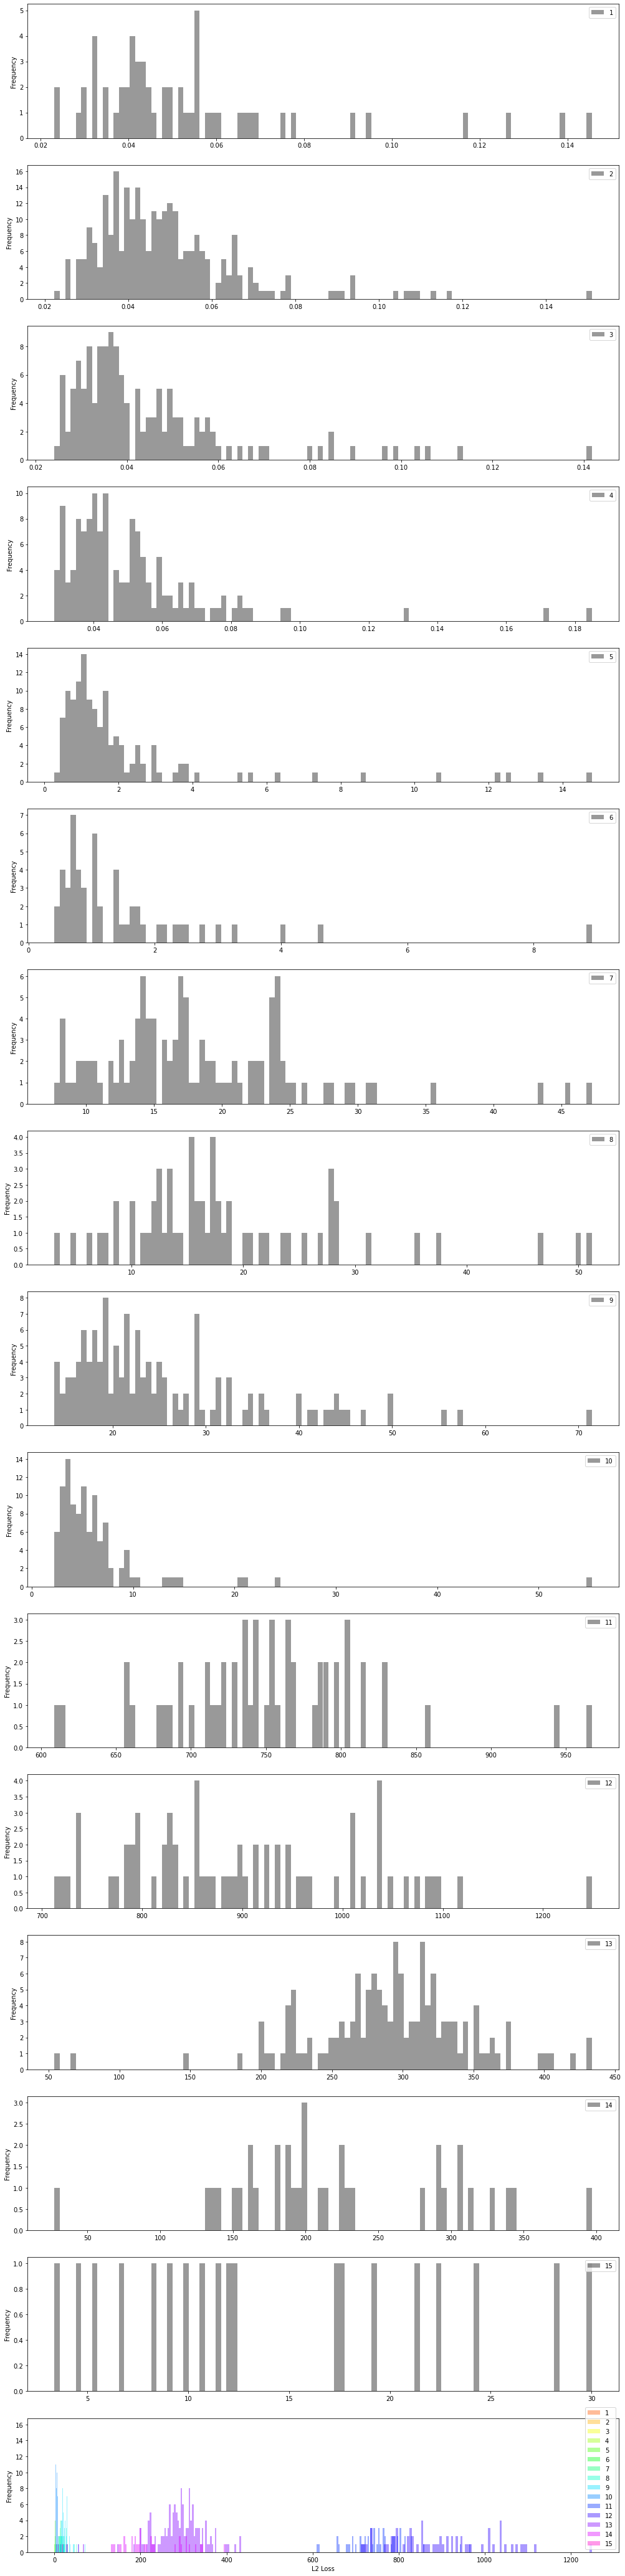

{1: [0.023114655166864395, 0.14553287625312805], 2: [0.02235587313771248, 0.1509130299091339], 3: [0.024099720641970634, 0.14174534380435944], 4: [0.028612667694687843, 0.1849086731672287], 5: [0.2692868113517761, 14.785019874572754], 6: [0.4111504852771759, 8.922633171081543], 7: [7.665680885314941, 47.217838287353516], 8: [3.122682809829712, 51.18281173706055], 9: [13.760334968566895, 71.43653106689453], 10: [2.2331016063690186, 55.25442886352539], 11: [609.0490112304688, 967.170166015625], 12: [712.3746337890625, 1248.7039794921875], 13: [54.104652404785156, 433.5475158691406], 14: [27.33151626586914, 396.7781982421875], 15: [3.363725423812866, 30.02029037475586]}


: 

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

losses = np.array(losses)
digits = np.array(digits)

loss_dict = {}


plt.figure(figsize=(17, 80))
for i in range(1,16):
    plt.subplot(17, 1, i+1)
    cur_losses = losses[digits==i];
    plt.hist(cur_losses, label=str(i), bins=100, color='k', alpha=0.4)
    plt.legend()
    plt.ylabel('Frequency')
    loss_dict[i] = [np.min(cur_losses),np.max(cur_losses)]
    plt.subplot(17, 1, 17)
    color = cm.hsv(i/17)
    plt.hist(losses[digits==i], label=str(i), bins=100, color=color, alpha=0.4)

plt.legend()
plt.xlabel('L2 Loss')
plt.ylabel('Frequency')
plt.show()

print(loss_dict)
